# Understanding REINFORCE (Monte Carlo Policy Gradient): A Complete Guide

# Table of Contents

- [Introduction](#introduction)
- [What is REINFORCE?](#what-is-reinforce)
  - [Why Policy Gradients?](#why-policy-gradients)
- [Where and How REINFORCE is Used](#where-and-how-reinforce-is-used)
- [Mathematical Foundation of REINFORCE](#mathematical-foundation-of-reinforce)
  - [Policy Gradient Theorem Recap (Intuition)](#policy-gradient-theorem-recap)
  - [The REINFORCE Objective Function](#the-reinforce-objective-function)
  - [The REINFORCE Gradient Estimator](#the-reinforce-gradient-estimator)
  - [Calculating Discounted Returns (Monte Carlo)](#calculating-discounted-returns)
- [Step-by-Step Explanation of REINFORCE](#step-by-step-explanation-of-reinforce)
- [Key Components of REINFORCE](#key-components-of-reinforce)
  - [Policy Network](#policy-network)
  - [Action Selection (Sampling)](#action-selection-sampling)
  - [Trajectory Collection](#trajectory-collection)
  - [Discounted Returns Calculation](#discounted-returns-calculation)
  - [Loss Function (Policy Gradient Objective)](#loss-function-policy-gradient-objective)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the REINFORCE Algorithm](#implementing-the-reinforce-algorithm)
  - [Defining the Policy Network](#defining-the-policy-network)
  - [Action Selection (Sampling from Policy)](#action-selection-sampling-from-policy)
  - [Calculating Returns](#calculating-returns)
  - [Optimization Step (Policy Update)](#optimization-step-policy-update)
- [Running the REINFORCE Algorithm](#running-the-reinforce-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Optional Visualization)](#analyzing-the-learned-policy-optional-visualization)
- [Common Challenges and Solutions in REINFORCE](#common-challenges-and-solutions-in-reinforce)
- [Conclusion](#conclusion)

## Introduction

Reinforcement Learning (RL) aims to train agents to make sequences of decisions in an environment to maximize a cumulative reward. While value-based methods like Q-learning (and DQN) learn the value of state-action pairs, policy-based methods directly learn a policy, which is a mapping from states to actions (or action probabilities). REINFORCE, also known as Monte Carlo Policy Gradient, is a foundational policy gradient algorithm.

## What is REINFORCE?

REINFORCE is an algorithm that learns a parameterized policy $\pi(a|s; \theta)$ directly, without explicitly learning a value function first. It works by:

1.  Executing the current policy $\pi(a|s; \theta)$ to generate full episodes (trajectories) of experience: $(s_0, a_0, r_1, s_1, a_1, r_2, ..., s_T)$.
2.  For each step $t$ in the episode, calculating the total discounted return $G_t = \sum_{k=t}^T \gamma^{k-t} r_{k+1}$ obtained from that step onwards.
3.  Updating the policy parameters $\theta$ using gradient ascent to increase the probability of actions $a_t$ that led to high returns $G_t$ and decrease the probability of actions that led to low returns.

It's considered a **Monte Carlo** method because it uses the complete return $G_t$ from entire episodes to update the policy, rather than bootstrapping from estimated values like Q-learning or Actor-Critic methods.

### Why Policy Gradients?

Policy gradient methods offer several advantages over purely value-based methods like DQN:

1.  **Continuous Action Spaces:** They can naturally handle continuous action spaces, whereas DQN is primarily designed for discrete actions.
2.  **Stochastic Policies:** They can learn stochastic policies ($pi(a|s)$ gives probabilities), which can be beneficial in partially observable environments or when seeking robustness.
3.  **Simpler Conceptually (in some ways):** Directly optimizing the policy can sometimes be more straightforward than estimating values, especially when the value function is complex.

However, basic policy gradient methods like REINFORCE often suffer from high variance in their gradient estimates due to the Monte Carlo sampling, which can lead to slower or less stable convergence compared to methods like DQN or Actor-Critic.

## Where and How REINFORCE is Used

REINFORCE serves as a fundamental building block for understanding more advanced policy gradient and actor-critic methods. While its high variance limits its direct application in complex, large-scale problems compared to state-of-the-art algorithms, it's effective for:

1.  **Simpler RL Benchmarks:** Problems like CartPole, Acrobot, or custom grid worlds where trajectories are relatively short and variance is manageable.
2.  **Learning Stochastic Policies:** Situations where a probabilistic action selection is desirable.
3.  **Educational Purposes:** Provides a clear introduction to the core concepts of policy gradient learning.

REINFORCE is suitable when:
- The goal is to directly learn a policy.
- The environment allows for generating full episodes before updating.
- The action space can be discrete or continuous (though our example uses discrete).
- High variance in updates is acceptable or can be managed (e.g., through baselines, though not implemented here).
- It operates **on-policy**, meaning the policy used to generate data is the same one being improved. Data from old policies cannot be easily reused (unlike DQN's off-policy nature with replay buffers).

## Mathematical Foundation of REINFORCE

### Policy Gradient Theorem Recap (Intuition)

The goal is to find policy parameters $\theta$ that maximize the expected total discounted return, often denoted as $J(\theta)$. The Policy Gradient Theorem provides a way to compute the gradient of this objective with respect to the policy parameters:
$$ \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t | s_t) Q^{\pi_\theta}(s_t, a_t) \right] $$
where $\tau$ is a trajectory sampled using policy $\pi_\theta$, and $Q^{\pi_\theta}(s_t, a_t)$ is the action-value function under policy $\pi_\theta$.

### The REINFORCE Objective Function

REINFORCE uses the Monte Carlo return $G_t = \sum_{k=t}^T \gamma^{k-t} r_{k+1}$ as an unbiased estimate of $Q^{\pi_\theta}(s_t, a_t)$. The gradient then becomes:
$$ \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T G_t \nabla_\theta \log \pi_\theta(a_t | s_t) \right] $$

We want to perform gradient *ascent* on $J(\theta)$. This is equivalent to performing gradient *descent* on the negative objective, which gives us the typical loss function used in implementations:
$$ L(\theta) = - \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^T G_t \log \pi_\theta(a_t | s_t) \right] $$

In practice, we approximate the expectation using samples (episodes) generated by the current policy.

### The REINFORCE Gradient Estimator

For a single trajectory $\tau$, the gradient estimate is $\sum_{t=0}^T G_t \nabla_\theta \log \pi_\theta(a_t | s_t)$.
The term $\nabla_\theta \log \pi_\theta(a_t | s_t)$ is often called the "eligibility vector". It indicates the direction in parameter space that increases the log-probability of taking action $a_t$ in state $s_t$. This direction is then scaled by the return $G_t$. If $G_t$ is high, we move significantly in that direction; if $G_t$ is low (or negative), we move away from that direction.

### Calculating Discounted Returns (Monte Carlo)

After an episode finishes and we have the sequence of rewards $r_1, r_2, ..., r_T$, we calculate the discounted return for each time step $t$:
$$ G_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + ... + \gamma^{T-t} r_T $$
This calculation is typically done efficiently by iterating backward from the end of the episode:
$G_T = 0$ (assuming $r_{T+1}=0$ or depends on problem setup)
$G_{T-1} = r_T + \gamma G_T$
$G_{T-2} = r_{T-1} + \gamma G_{T-1}$
... and so on until $G_0$.

**Variance Reduction (Baselines):** A common technique (though not implemented in this basic example) is to subtract a state-dependent baseline $b(s_t)$ (often the state-value function $V(s_t)$) from the return: $
abla_	heta J(\theta) \approx \sum_t (G_t - b(s_t)) \nabla_\theta \log \pi_\theta(a_t|s_t)$. This doesn't change the expected gradient but significantly reduces its variance.

## Step-by-Step Explanation of REINFORCE

1.  **Initialize**: Policy network $\pi(a|s; \theta)$ with random weights $\theta$, discount factor $\gamma$, learning rate $\alpha$.
2.  **For each episode**: \
    a.  Generate a full trajectory $\tau = (s_0, a_0, r_1, s_1, a_1, ..., s_{T-1}, a_{T-1}, r_T, s_T)$ by following policy $\pi(a|s; \theta)$: \
        i.  For $t=0, 1, ..., T-1$:
            - Observe state $s_t$. \
            - Sample action $a_t \sim \pi(\cdot | s_t; \theta)$. \
            - Execute $a_t$, observe reward $r_{t+1}$ and next state $s_{t+1}$. \
            - Store $s_t, a_t, r_{t+1}$, and $\log \pi_\theta(a_t | s_t)$. \
    b.  **Calculate Returns**: For $t=0, 1, ..., T-1$: \
        - Compute the discounted return $G_t = \sum_{k=t}^{T-1} \gamma^{k-t} r_{k+1}$. \
    c.  **Update Policy**: Perform gradient ascent (or descent on the negative objective): \
        - Compute the loss $L = -\sum_{t=0}^{T-1} G_t \log \pi_\theta(a_t | s_t)$. \
        - Update weights: $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$ (or using an optimizer on $L$). \
3.  **Repeat**: Until convergence or max episodes.

## Key Components of REINFORCE

### Policy Network
- The core function approximator. Learns to map states to action probabilities.
- Architecture depends on the state representation (MLP for vectors, CNN for images).
- Uses non-linear activation functions (like ReLU) in hidden layers.
- Output layer typically uses a **Softmax** activation for discrete action spaces to produce a probability distribution over actions.

### Action Selection (Sampling)
- Actions are **sampled** from the probability distribution output by the policy network $\pi(a|s; \theta)$.
- This inherently provides exploration. As learning progresses, probabilities for better actions increase, leading to more exploitation.
- Requires storing the **log probability** of the chosen action ($log \pi(a_t|s_t; \theta)$) for the gradient calculation.

### Trajectory Collection
- REINFORCE is **on-policy** and **episodic**.
- It requires collecting full episodes (state, action, reward sequences) using the current policy before an update can be made.
- Stores rewards, states, actions, and log probabilities for each step.

### Discounted Returns Calculation
- After an episode, calculate $G_t$ for every step $t$.
- This value represents the actual cumulative reward received from that point onwards in that specific episode.

### Loss Function (Policy Gradient Objective)
- Typically $-\sum_t G_t \log \pi(a_t|s_t; \theta)$.
- Maximizing the probability of actions that led to high returns.
- Often, returns $G_t$ are **standardized** (subtract mean, divide by std dev) across the episode's batch of returns to stabilize learning.

### Hyperparameters
- Key hyperparameters include learning rate, discount factor $\gamma$, and network architecture.
- Performance can be sensitive to these, especially the learning rate, due to the variance of the gradient estimate.

## Practical Example: Custom Grid World

We'll use the same simple, custom Grid World environment as in the DQN example for comparison and to adhere to the style.

**Environment Description:**
- **Grid Size:** 10x10.
- **State:** Agent's `(row, col)` position. Represented as a normalized vector `[row/10, col/10]` for the network input.
- **Actions:** 4 discrete actions: 0 (up), 1 (down), 2 (left), 3 (right).
- **Start State:** (0, 0).
- **Goal State:** (9, 9).
- **Rewards:**
    - +10 for reaching the goal state (9, 9).
    - -1 for hitting a wall (attempting to move off-grid).
    - -0.1 for any other step (small cost to encourage efficiency).
- **Termination:** Episode ends when the agent reaches the goal or after a maximum number of steps.

# Setting up the Environment

Import required libraries and set up the environment.

In [1]:
# Import necessary libraries for numerical computations, plotting, and utility functions
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque # Deque might not be needed for REINFORCE
from itertools import count
from typing import List, Tuple, Dict, Optional

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical # Needed for sampling actions

# Set up the device to use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set a random seed for reproducibility across runs
seed = 42
random.seed(seed)  # Seed for Python's random module
np.random.seed(seed)  # Seed for NumPy
torch.manual_seed(seed)  # Seed for PyTorch (CPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # Seed for PyTorch (GPU)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

Using device: cpu


# Creating the Custom Environment

We reuse the exact same `GridEnvironment` class from the DQN notebook. This ensures comparability and adheres to the reference style.

In [2]:
# Custom Grid World Environment (Identical to the one in DQN notebook)
class GridEnvironment:
    """
    A simple 10x10 Grid World environment.
    State: (row, col) represented as normalized vector [row/10, col/10].
    Actions: 0 (up), 1 (down), 2 (left), 3 (right).
    Rewards: +10 for reaching the goal, -1 for hitting a wall, -0.1 for each step.
    """

    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        """
        Initializes the Grid World environment.

        Parameters:
        - rows (int): Number of rows in the grid.
        - cols (int): Number of columns in the grid.
        """
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)  # Starting position
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)  # Goal position
        self.state: Tuple[int, int] = self.start_state  # Current state
        self.state_dim: int = 2  # State represented by 2 coordinates (row, col)
        self.action_dim: int = 4  # 4 discrete actions: up, down, left, right

        # Action mapping: maps action index to (row_delta, col_delta)
        self.action_map: Dict[int, Tuple[int, int]] = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, -1),  # Left
            3: (0, 1)    # Right
        }

    def reset(self) -> torch.Tensor:
        """
        Resets the environment to the start state.

        Returns:
            torch.Tensor: The initial state as a normalized tensor.
        """
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        """
        Converts a (row, col) tuple to a normalized tensor for the network.

        Parameters:
        - state_tuple (Tuple[int, int]): The state represented as a tuple (row, col).

        Returns:
            torch.Tensor: The normalized state as a tensor.
        """
        # Normalize coordinates to be between 0 and 1 (adjust normalization slightly for 0-based indexing)
        normalized_state: List[float] = [
            state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0,
            state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        ]
        return torch.tensor(normalized_state, dtype=torch.float32, device=device)

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        """
        Performs one step in the environment based on the given action.

        Args:
            action (int): The action to take (0: up, 1: down, 2: left, 3: right).

        Returns:
            Tuple[torch.Tensor, float, bool]: 
                - next_state_tensor (torch.Tensor): The next state as a normalized tensor.
                - reward (float): The reward for the action.
                - done (bool): Whether the episode has ended.
        """
        # If the goal state is already reached, return the current state with 0 reward and done=True
        if self.state == self.goal_state:
            return self._get_state_tensor(self.state), 0.0, True

        # Get the row and column deltas for the action
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc

        # Default step cost
        reward: float = -0.1
        hit_wall: bool = False

        # Check if the action leads to hitting a wall (out of bounds)
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            # Stay in the same state and incur a penalty
            next_row, next_col = current_row, current_col
            reward = -1.0
            hit_wall = True

        # Update the state
        self.state = (next_row, next_col)
        next_state_tensor: torch.Tensor = self._get_state_tensor(self.state)

        # Check if the goal state is reached
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0  # Reward for reaching the goal

        return next_state_tensor, reward, done

    def get_action_space_size(self) -> int:
        """
        Returns the size of the action space.

        Returns:
            int: The number of possible actions (4).
        """
        return self.action_dim

    def get_state_dimension(self) -> int:
        """
        Returns the dimension of the state representation.

        Returns:
            int: The number of dimensions in the state (2).
        """
        return self.state_dim

Instantiate the custom environment and verify its properties.

In [3]:
# Instantiate the custom grid environment with a 10x10 grid
custom_env = GridEnvironment(rows=10, cols=10)

# Get the size of the action space and state dimension
n_actions_custom = custom_env.get_action_space_size()
n_observations_custom = custom_env.get_state_dimension()

# Print basic information about the environment
print(f"Custom Grid Environment:")
print(f"Size: {custom_env.rows}x{custom_env.cols}")
print(f"State Dim: {n_observations_custom}")
print(f"Action Dim: {n_actions_custom}")
print(f"Start State: {custom_env.start_state}")
print(f"Goal State: {custom_env.goal_state}")

# Reset the environment and print the normalized state tensor for the start state
print(f"Example state tensor for (0,0): {custom_env.reset()}")

# Take an example step: move 'right' (action=3) and print the result
next_s, r, d = custom_env.step(3) # Action 3 corresponds to moving right
print(f"Step result (action=right): next_state={next_s.cpu().numpy()}, reward={r}, done={d}")

# Take another example step: move 'up' (action=0) and print the result
# This should hit a wall since the agent is at the top row
next_s, r, d = custom_env.step(0) # Action 0 corresponds to moving up
print(f"Step result (action=up): next_state={next_s.cpu().numpy()}, reward={r}, done={d}")

Custom Grid Environment:
Size: 10x10
State Dim: 2
Action Dim: 4
Start State: (0, 0)
Goal State: (9, 9)
Example state tensor for (0,0): tensor([0., 0.])
Step result (action=right): next_state=[0.         0.11111111], reward=-0.1, done=False
Step result (action=up): next_state=[0.         0.11111111], reward=-1.0, done=False


# Implementing the REINFORCE Algorithm

Now, let's implement the core components: the Policy Network, the action selection mechanism (sampling), the return calculation, and the policy update step.

### Defining the Policy Network

We define a simple Multi-Layer Perceptron (MLP) using PyTorch's `nn.Module`. The key difference from the DQN network is the output layer, which uses `nn.Softmax` to produce action probabilities.

In [5]:
# Define the Policy Network architecture
class PolicyNetwork(nn.Module):
    """ Simple MLP Policy Network for REINFORCE """
    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize the Policy Network.

        Parameters:
        - n_observations (int): Dimension of the state space.
        - n_actions (int): Number of possible actions.
        """
        super(PolicyNetwork, self).__init__()
        # Define network layers (similar structure to DQN reference)
        self.layer1 = nn.Linear(n_observations, 128) # Input layer
        self.layer2 = nn.Linear(128, 128)            # Hidden layer
        self.layer3 = nn.Linear(128, n_actions)      # Output layer (action logits)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network to get action probabilities.

        Parameters:
        - x (torch.Tensor): Input tensor representing the state(s).

        Returns:
        - torch.Tensor: Output tensor representing action probabilities (after Softmax).
        """
        # Ensure input is float tensor
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)

        # Apply layers with ReLU activation for hidden layers
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        # Get action logits from the output layer
        action_logits = self.layer3(x)
        # Apply Softmax to get action probabilities
        action_probs = F.softmax(action_logits, dim=-1) # Use dim=-1 for generality (works for batches)
        return action_probs

### Action Selection (Sampling from Policy)

This function selects an action by sampling from the probability distribution provided by the policy network. It also returns the log probability of the selected action, which is needed for the REINFORCE update.

In [6]:
# Action Selection for REINFORCE
def select_action_reinforce(state: torch.Tensor, policy_net: PolicyNetwork) -> Tuple[int, torch.Tensor]:
    """
    Selects an action by sampling from the policy network's output distribution.

    Parameters:
    - state (torch.Tensor): The current state as a tensor of shape [state_dim].
    - policy_net (PolicyNetwork): The policy network used to estimate action probabilities.

    Returns:
    - Tuple[int, torch.Tensor]:
        - action (int): The selected action index.
        - log_prob (torch.Tensor): The log probability of the selected action.
    """
    # Ensure the network is in evaluation mode if it has dropout/batchnorm layers (optional here)
    # policy_net.eval() 

    # Get action probabilities from the policy network
    # Add batch dimension if state is single instance [state_dim] -> [1, state_dim]
    if state.dim() == 1:
        state = state.unsqueeze(0)
    
    action_probs = policy_net(state)

    # Create a categorical distribution over the actions
    # Squeeze(0) if we added a batch dimension earlier to get probs for the single state
    m = Categorical(action_probs.squeeze(0)) 
    
    # Sample an action from the distribution
    action = m.sample()
    
    # Get the log probability of the sampled action (needed for gradient calculation)
    log_prob = m.log_prob(action)

    # Put network back to training mode if needed
    # policy_net.train()

    # Return the action index (as int) and its log probability (as tensor)
    return action.item(), log_prob

### Calculating Returns

This function calculates the discounted returns $G_t$ for each step in an episode, given the list of rewards. It optionally standardizes the returns.

In [7]:
def calculate_discounted_returns(rewards: List[float], gamma: float, standardize: bool = True) -> torch.Tensor:
    """
    Calculates the discounted returns G_t for each step t in an episode.

    Parameters:
    - rewards (List[float]): List of rewards received during the episode.
    - gamma (float): The discount factor.
    - standardize (bool): Whether to standardize (normalize) the returns (subtract mean, divide by std).

    Returns:
    - torch.Tensor: A tensor containing the discounted return for each step.
    """
    n_steps = len(rewards)
    returns = torch.zeros(n_steps, device=device, dtype=torch.float32)
    discounted_return = 0.0

    # Iterate backwards through the rewards to calculate discounted returns
    for t in reversed(range(n_steps)):
        discounted_return = rewards[t] + gamma * discounted_return
        returns[t] = discounted_return

    # Standardize returns (optional but often helpful)
    if standardize:
        mean_return = torch.mean(returns)
        std_return = torch.std(returns) + 1e-8 # Add small epsilon to prevent division by zero
        returns = (returns - mean_return) / std_return

    return returns

### Optimization Step (Policy Update)

This function performs the policy update after an episode is completed. It takes the collected log probabilities and calculated returns to compute the loss and perform backpropagation.

In [8]:
def optimize_policy(
    log_probs: List[torch.Tensor], 
    returns: torch.Tensor, 
    optimizer: optim.Optimizer
) -> float:
    """
    Performs one step of optimization on the policy network using REINFORCE update rule.

    Parameters:
    - log_probs (List[torch.Tensor]): List of log probabilities of actions taken in the episode.
    - returns (torch.Tensor): Tensor of discounted returns for each step in the episode.
    - optimizer (optim.Optimizer): The optimizer for updating the policy network.

    Returns:
    - float: The computed loss value for the episode.
    """
    # Stack log probabilities into a single tensor
    log_probs_tensor = torch.stack(log_probs)

    # Calculate the REINFORCE loss: - (returns * log_probs)
    # We want to maximize E[G_t * log(pi)], so we minimize -E[G_t * log(pi)]
    # Sum over the episode steps
    loss = -torch.sum(returns * log_probs_tensor)

    # Perform backpropagation and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()       # Compute gradients
    optimizer.step()      # Update the policy network parameters

    return loss.item()    # Return the loss value for logging

# Running the REINFORCE Algorithm

Set up the hyperparameters, initialize the policy network and optimizer, then run the main training loop.

### Hyperparameter Setup

Define hyperparameters for the REINFORCE algorithm applied to the custom grid world.

In [9]:
# Hyperparameters for REINFORCE on Custom Grid World
GAMMA_REINFORCE = 0.99         # Discount factor
LR_REINFORCE = 1e-3            # Learning rate (often lower than DQN, sensitive)
NUM_EPISODES_REINFORCE = 1500  # REINFORCE often needs more episodes due to variance
MAX_STEPS_PER_EPISODE_REINFORCE = 200 # Max steps per episode
STANDARDIZE_RETURNS = True     # Whether to standardize returns

### Initialization

Initialize the policy network and the optimizer.

In [10]:
# Re-instantiate the custom GridEnvironment
custom_env: GridEnvironment = GridEnvironment(rows=10, cols=10)

# Get the size of the action space and state dimension
n_actions_custom: int = custom_env.get_action_space_size()  # 4 actions
n_observations_custom: int = custom_env.get_state_dimension()  # 2 state dimensions

# Initialize the policy network
policy_net_reinforce: PolicyNetwork = PolicyNetwork(n_observations_custom, n_actions_custom).to(device)

# Initialize the optimizer for the policy network
optimizer_reinforce: optim.Adam = optim.Adam(policy_net_reinforce.parameters(), lr=LR_REINFORCE)

# Lists for storing episode statistics for plotting
episode_rewards_reinforce = []
episode_lengths_reinforce = []
episode_losses_reinforce = []

### Training Loop

Train the REINFORCE agent on the custom grid world environment. Note the difference in workflow compared to DQN: we collect a full episode first, then calculate returns and update the policy.

In [11]:
print("Starting REINFORCE Training on Custom Grid World...")

# Training Loop
for i_episode in range(NUM_EPISODES_REINFORCE):
    # Reset the environment and get the initial state tensor
    state = custom_env.reset()
    
    # Lists to store data for the current episode
    episode_log_probs: List[torch.Tensor] = []
    episode_rewards: List[float] = []
    
    # --- Generate one episode --- 
    for t in range(MAX_STEPS_PER_EPISODE_REINFORCE):
        # Select action based on current policy and store log probability
        action, log_prob = select_action_reinforce(state, policy_net_reinforce)
        episode_log_probs.append(log_prob)
        
        # Take action in the environment
        next_state, reward, done = custom_env.step(action)
        episode_rewards.append(reward)
        
        # Move to the next state
        state = next_state
        
        # Break if the episode finished
        if done:
            break
            
    # --- Episode finished, now update the policy --- 
    
    # Calculate discounted returns for the episode
    returns = calculate_discounted_returns(episode_rewards, GAMMA_REINFORCE, STANDARDIZE_RETURNS)
    
    # Perform policy optimization
    loss = optimize_policy(episode_log_probs, returns, optimizer_reinforce)
    
    # Store episode statistics
    total_reward = sum(episode_rewards)
    episode_rewards_reinforce.append(total_reward)
    episode_lengths_reinforce.append(t + 1)
    episode_losses_reinforce.append(loss)

    # Print progress periodically (e.g., every 100 episodes)
    if (i_episode + 1) % 100 == 0:
        avg_reward = np.mean(episode_rewards_reinforce[-100:])
        avg_length = np.mean(episode_lengths_reinforce[-100:])
        avg_loss = np.mean(episode_losses_reinforce[-100:])
        print(
            f"Episode {i_episode+1}/{NUM_EPISODES_REINFORCE} | "
            f"Avg Reward (last 100): {avg_reward:.2f} | "
            f"Avg Length: {avg_length:.2f} | "
            f"Avg Loss: {avg_loss:.4f}"
        )

print("Custom Grid World Training Finished (REINFORCE).")

Starting REINFORCE Training on Custom Grid World...
Episode 100/1500 | Avg Reward (last 100): 1.16 | Avg Length: 43.05 | Avg Loss: -1.9560
Episode 200/1500 | Avg Reward (last 100): 5.64 | Avg Length: 21.88 | Avg Loss: -1.9926
Episode 300/1500 | Avg Reward (last 100): 6.72 | Avg Length: 19.85 | Avg Loss: -0.9519
Episode 400/1500 | Avg Reward (last 100): 7.17 | Avg Length: 19.22 | Avg Loss: -0.5228
Episode 500/1500 | Avg Reward (last 100): 7.55 | Avg Length: 18.89 | Avg Loss: -0.3537
Episode 600/1500 | Avg Reward (last 100): 7.39 | Avg Length: 19.09 | Avg Loss: -0.2147
Episode 700/1500 | Avg Reward (last 100): 7.26 | Avg Length: 19.29 | Avg Loss: 0.2578
Episode 800/1500 | Avg Reward (last 100): 7.93 | Avg Length: 18.71 | Avg Loss: -0.5481
Episode 900/1500 | Avg Reward (last 100): 8.02 | Avg Length: 18.42 | Avg Loss: -0.8681
Episode 1000/1500 | Avg Reward (last 100): 7.58 | Avg Length: 18.83 | Avg Loss: -0.3242
Episode 1100/1500 | Avg Reward (last 100): 7.49 | Avg Length: 18.94 | Avg Loss

# Visualizing the Learning Process

Plot the results (rewards, episode lengths) for the REINFORCE agent on the custom Grid World environment.

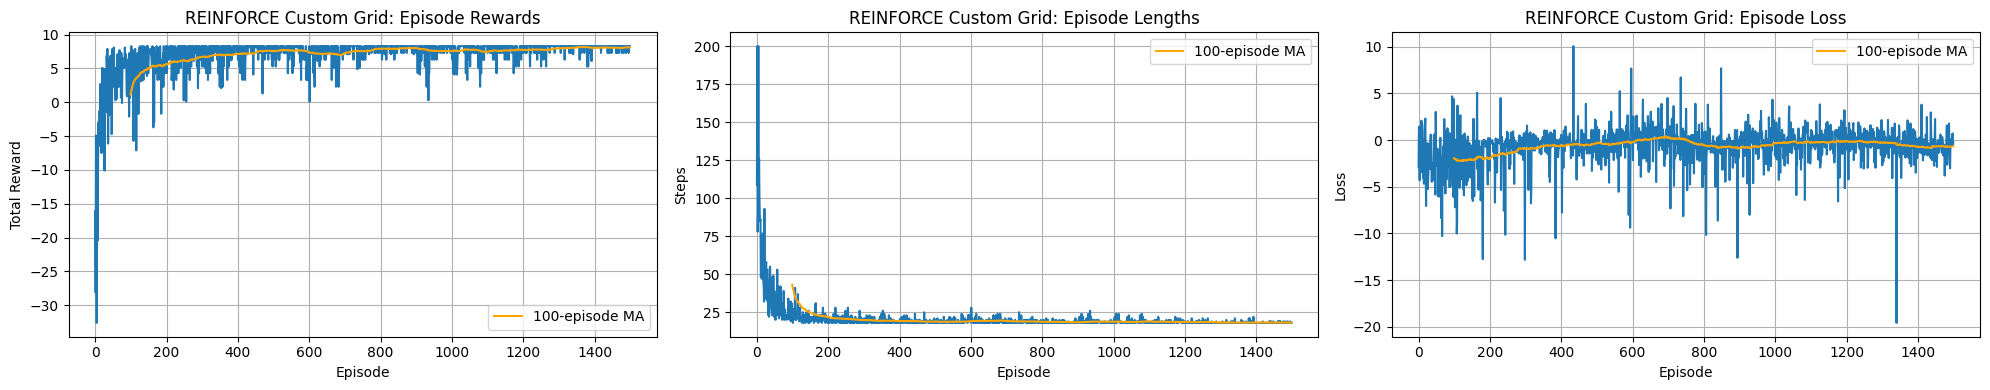

In [12]:
# Plotting results for REINFORCE on Custom Grid World
plt.figure(figsize=(20, 4))

# Rewards
plt.subplot(1, 3, 1)
plt.plot(episode_rewards_reinforce)
plt.title('REINFORCE Custom Grid: Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
# Add moving average
rewards_ma_reinforce = np.convolve(episode_rewards_reinforce, np.ones(100)/100, mode='valid')
if len(rewards_ma_reinforce) > 0: 
    plt.plot(np.arange(len(rewards_ma_reinforce)) + 99, rewards_ma_reinforce, label='100-episode MA', color='orange')
plt.legend()

# Lengths
plt.subplot(1, 3, 2)
plt.plot(episode_lengths_reinforce)
plt.title('REINFORCE Custom Grid: Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
# Add moving average
lengths_ma_reinforce = np.convolve(episode_lengths_reinforce, np.ones(100)/100, mode='valid')
if len(lengths_ma_reinforce) > 0:
    plt.plot(np.arange(len(lengths_ma_reinforce)) + 99, lengths_ma_reinforce, label='100-episode MA', color='orange')
plt.legend()

# Loss
plt.subplot(1, 3, 3)
plt.plot(episode_losses_reinforce)
plt.title('REINFORCE Custom Grid: Episode Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid(True)
# Add moving average
losses_ma_reinforce = np.convolve(episode_losses_reinforce, np.ones(100)/100, mode='valid')
if len(losses_ma_reinforce) > 0:
    plt.plot(np.arange(len(losses_ma_reinforce)) + 99, losses_ma_reinforce, label='100-episode MA', color='orange')
plt.legend()

plt.tight_layout()
plt.show()

**Analysis of REINFORCE Learning Curves (Custom Grid World):**

1.  **Episode Rewards (Left Plot):**
    The agent shows very fast initial learning, rapidly increasing episode rewards to near-optimal levels within ~150 episodes. The moving average confirms convergence to a high reward policy. However, the raw rewards remain highly volatile throughout training, showcasing the characteristic high variance of the basic REINFORCE algorithm due to using noisy Monte Carlo returns for updates.

2.  **Episode Lengths (Middle Plot):**
    This plot strongly confirms efficient learning, mirroring the reward curve's trend. Episode lengths plummet dramatically early on, quickly converging to a stable, near-optimal average around 18 steps (the shortest path in the 10x10 grid). This indicates the agent successfully learned to find efficient paths to the goal state consistently.

3.  **Episode Loss (Right Plot):**
    The policy gradient loss exhibits extreme variance, directly reflecting the noisy Monte Carlo return estimates used in REINFORCE updates. Unlike MSE loss, it doesn't converge to zero but stabilizes on average after the initial learning phase. This high variance in the loss/gradient estimate is the primary reason for the volatility seen in the rewards curve.

**Overall Conclusion:**
REINFORCE successfully and quickly solved the custom Grid World task, learning an efficient policy to maximize rewards. The plots clearly demonstrate rapid convergence but also highlight the algorithm's inherent high variance in reward signals and gradient estimates, a key limitation compared to more advanced policy gradient or actor-critic methods.

# Analyzing the Learned Policy (Optional Visualization)

We adapt the policy grid visualization from the DQN notebook to use the Policy Network. It shows the most probable action (argmax of the policy output) for each state.


Plotting Learned Policy from REINFORCE:


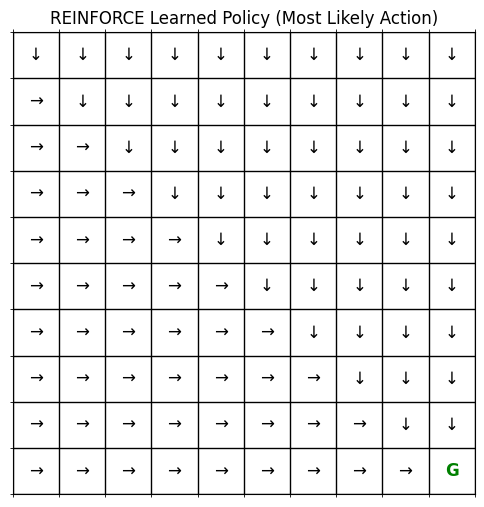

In [13]:
def plot_reinforce_policy_grid(policy_net: PolicyNetwork, env: GridEnvironment, device: torch.device) -> None:
    """
    Plots the greedy policy derived from the REINFORCE policy network.
    Note: Shows the most likely action, not a sample.

    Parameters:
    - policy_net (PolicyNetwork): The trained policy network.
    - env (GridEnvironment): The custom grid environment.
    - device (torch.device): The device (CPU/GPU).

    Returns:
    - None: Displays the policy grid plot.
    """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)
            if state_tuple == env.goal_state:
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                state_tensor: torch.Tensor = env._get_state_tensor(state_tuple)
                with torch.no_grad():
                    state_tensor = state_tensor.unsqueeze(0)
                    # Get action probabilities
                    action_probs: torch.Tensor = policy_net(state_tensor)
                    # Select the action with the highest probability (greedy action)
                    best_action: int = action_probs.argmax(dim=1).item()

                policy_grid[r, c] = action_symbols[best_action]
                ax.text(c, r, policy_grid[r, c], ha='center', va='center', color='black', fontsize=12)

    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("REINFORCE Learned Policy (Most Likely Action)")
    plt.show()

# Plot the policy learned by the trained network
print("\nPlotting Learned Policy from REINFORCE:")
plot_reinforce_policy_grid(policy_net_reinforce, custom_env, device)

## Common Challenges and Solutions in REINFORCE

**Challenge: High Variance in Gradient Estimates**
*   **Problem:** Using the full Monte Carlo return $G_t$ makes the gradient estimate noisy, as a single good or bad action early in a long episode can unduly affect the updates for all preceding actions, even unrelated ones.
*   **Solutions**:
    *   **Baseline Subtraction:** Subtract a state-dependent baseline (like the state value $V(s_t)$) from $G_t$: update using $(G_t - V(s_t)) \nabla \log \pi$. This reduces variance without biasing the gradient. Requires learning $V(s_t)$, leading towards Actor-Critic methods.
    *   **Standardize Returns:** Normalize the returns within an episode or batch (subtract mean, divide by standard deviation). This helps stabilize updates.
    *   **Increase Batch Size:** Average gradients over multiple episodes before updating (though this requires more memory).

**Challenge: Slow Convergence**
*   **Problem:** High variance and potentially small learning steps can lead to slow learning.
*   **Solutions**:
    *   **Tune Learning Rate:** Careful tuning is crucial. Adaptive learning rates (Adam optimizer is often used) can help.
    *   **Use Baselines:** As mentioned above, variance reduction speeds up convergence.
    *   **Actor-Critic Methods:** Replace Monte Carlo returns $G_t$ with bootstrapped estimates like the TD error from a learned critic (value function), leading to faster, lower-variance updates (e.g., A2C, A3C).

**Challenge: On-Policy Data Inefficiency**
*   **Problem:** REINFORCE must discard data after each policy update, making it less sample efficient than off-policy methods like DQN.
*   **Solutions**:
    *   **Importance Sampling:** Techniques used in off-policy policy gradient methods (like PPO) allow reusing old data to some extent, but add complexity.
    *   **Accept the Limitation:** For simpler problems or when interaction cost is low, the simplicity of on-policy updates might be preferred.

## Conclusion

REINFORCE is a foundational policy gradient algorithm in reinforcement learning. It directly optimizes a parameterized policy by adjusting action probabilities based on the complete discounted returns obtained during episodes. Its core strength lies in its conceptual simplicity and ability to handle various action spaces and learn stochastic policies.

As demonstrated with the custom Grid World, REINFORCE can learn effective policies. However, its practical application is often limited by the high variance inherent in its Monte Carlo gradient estimates, which can lead to instability or slow convergence. Techniques like baseline subtraction and return standardization are common additions to mitigate this. REINFORCE serves as a crucial stepping stone to understanding more advanced and widely used policy gradient and actor-critic methods (like A2C, A3C, DDPG, PPO, SAC) which build upon its core principles while addressing its limitations, particularly variance and sample efficiency.